# Multi-label Legal Text Classification for CIA

## Models and Experiments: Adaptive Pre-Training with Sentence BERT Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import gzip
import random
import time
from tabulate import tabulate

In [2]:
from functions.source_parsing import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast, BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from sentence_transformers import models, losses, datasets
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from sentence_transformers.datasets import DenoisingAutoEncoderDataset
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from tqdm import trange
import math
import logging
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("../..")
os.getcwd()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Prepare data

In [4]:
# training data (by sentence)
text = pd.read_csv("data/01 legal_texts_pipeline_sentence.csv")

In [5]:
# for sentences
text['sentence_clean'] = text['sentence_clean'].astype(str)
text_list = text['sentence_clean'].values.tolist()

In [6]:
oecd_defs = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0).rename(columns={'text_clean': 'defs_text'}) # oecd definitions
oecd_defs.at[3, 'Main'] = 'Others' # change category D to "Others"

train_df_augmented = pd.read_csv("data/01 train_data_augmented.csv", index_col=0).rename(columns={'text_clean': 'legal_text'}) # labeled training data augmented
test_df = pd.read_csv("data/01 test_data.csv", index_col=0).rename(columns={'text_clean': 'legal_text'}) # labeled test data

In [7]:
train_df_augmented['legal_text'] = preprocess_corpus_keep_stop_words(train_df_augmented['Text'])
train_df_augmented['legal_text'] = [lemmatize(text) for text in train_df_augmented['legal_text']]

test_df['legal_text'] = preprocess_corpus_keep_stop_words(test_df['Text'])
test_df['legal_text'] = [lemmatize(text) for text in test_df['legal_text']]

### I. Base BERT Models

Code from this section is based on https://github.com/janinepdevera/document-classification-BERT

#### A. BERT for binary classification


In [8]:
# create binary_label column
train_df_augmented['binary_label'] = train_df_augmented['Category_New'].apply(lambda x: 0 if x == "None" else 1)
train_df_augmented.drop_duplicates(subset=('legal_text', 'binary_label'), keep='first')

test_df['binary_label'] = test_df['Category_New'].apply(lambda x: 0 if x == "None" else 1)
test_df_binary = test_df.drop_duplicates(subset=('legal_text', 'binary_label'), keep='first')

In [9]:
# bert-base-uncased
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', return_dict=False)

# legal-bert-base-uncased
legal_bert = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased", return_dict=False)
legal_tokenizer = BertTokenizerFast.from_pretrained("nlpaueb/legal-bert-base-uncased", return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bi

In [10]:
train_df_sample = train_df_augmented.sample(500)
test_df_sample = test_df_binary.sample(300)

In [11]:
test_df_sample['binary_label'].value_counts()

1    190
0    110
Name: binary_label, dtype: int64

In [30]:
train_text = train_df_augmented['legal_text'].to_list()
test_text = test_df['legal_text'].to_list()

train_labels = train_df_augmented['binary_label'].to_list()
test_labels = test_df['binary_label'].to_list()

In [31]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
# convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [33]:
batch_size = 8
num_workers = 2

# dataLoader for train set
train_data = TensorDataset(train_seq, train_mask, train_y)
train_dataloader = DataLoader(train_data, num_workers=num_workers, shuffle=True, batch_size=batch_size)

# dataLoader for test set
test_data = TensorDataset(test_seq, test_mask, test_y)
test_dataloader = DataLoader(test_data, num_workers=num_workers, shuffle=True, batch_size=batch_size)

In [51]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.3)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,1)
      #self.softmax = nn.LogSoftmax(dim=1)
      self.sigmoid = nn.Sigmoid()

    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      #x = self.softmax(x)
      x = self.sigmoid(x)

      return x

In [52]:
# method to freeze all the parameters if freeze = T
def set_parameter_requires_grad(model, freeze):
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

In [53]:
set_parameter_requires_grad(model=bert, freeze=True)
bert_classifier = BERT_Arch(bert)

In [54]:
device = 'cpu'

In [55]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  total_preds = []
  total_labels = []
  
  for inputs in tqdm(dataloader):
    
    # push to gpu
    inputs = [r.to(device) for r in inputs]
    sent_id, mask, labels = inputs

    # zero the parameter gradients
    model.zero_grad()        

    # forward + backward + optimize 
    preds = model(sent_id, mask)
    #loss = criterion(preds, labels)
    loss = criterion(preds.view(-1), labels.float())
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #prevent exploding gradient problem
    optimizer.step()

    total_labels.append(labels)
    #total_preds.append(preds.argmax(dim=-1))
    total_preds.append(preds)

  total_labels = torch.cat(total_labels)
  total_preds = torch.cat(total_preds)
  total_preds = (total_preds > 0.5).float()
  
  # epoch loss and accuracy
  epoch_loss = total_loss / len(dataloader)
  epoch_acc = accuracy_score(total_labels.detach().numpy(), total_preds.detach().numpy().argmax(axis=1))
  #epoch_f1 = f1_score(total_labels, total_preds, average='weighted')

  return epoch_loss, epoch_acc


In [56]:
def evaluate(model, dataloader, criterion):
  model.eval()
  total_loss = 0
  total_preds = []
  total_labels = []

  for inputs in tqdm(dataloader):
    
    # push to gpu
    inputs = [t.to(device) for t in inputs]
    sent_id, mask, labels = inputs

    with torch.no_grad():
      preds = model(sent_id, mask)
      #loss = criterion(preds,labels)
      loss = criterion(preds.view(-1), labels.float())
      total_loss += loss.item()

      total_labels.append(labels)
      #total_preds.append(preds.argmax(dim=-1))
      total_preds.append(preds)
   
  total_labels = torch.cat(total_labels)
  total_preds = torch.cat(total_preds)
  total_preds = (total_preds > 0.5).float()

  # epoch loss and model predictions
  epoch_loss = total_loss / len(dataloader)
  epoch_acc = accuracy_score(total_labels.detach().numpy(), total_preds.detach().numpy().argmax(axis=1))
  #epoch_f1 = f1_score(total_labels, total_preds, average='weighted')


  return epoch_loss, epoch_acc

In [57]:
def fit(model, criterion, train_loader, val_loader, epochs, path):
    best_valid_loss = float('inf')

    train_losses=[]
    valid_losses=[]

    for epoch in range(epochs):
        
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion)
        
        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path)
        
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"Train Loss: {train_loss:.2f}")
        print(f"Validation Loss: {valid_loss:.2f}")
        print(f"Train Accuracy: {train_acc:.3f}")
        print(f"Validation Accuracy: {valid_acc:.3f}")

In [58]:
epochs = 1
learning_rate = 1e-5

optimizer = AdamW(bert_classifier.parameters(), lr = learning_rate)
criterion  = nn.BCEWithLogitsLoss()

In [59]:
fit(bert_classifier, criterion, train_dataloader, test_dataloader, epochs, 'models/bert-'+datetime.now().strftime("%Y-%m-%d_%H-%M")+'.pt')


 Epoch 1 / 1


100%|██████████| 89/89 [05:16<00:00,  3.56s/it]


Train Loss: 0.49
Validation Loss: 0.63
Train Accuracy: 0.152
Validation Accuracy: 0.318


In [60]:
path = 'models/bert-2023-05-07_21-24.pt'
bert_classifier.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = bert_classifier(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [108]:
# generate classification report
report = classification_report(test_labels, preds, zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['0', '1', '2', '3', '4']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

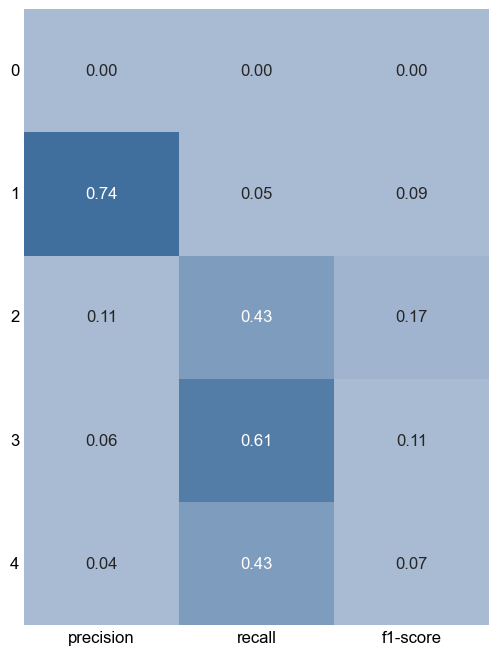

In [109]:
custom_cmap_blues = sns.color_palette(['#A9BBD3', '#A0B4CF', '#8FA8C6', '#7E9CBD', '#6D8FB4', '#537CA6', '#416F9D', '#306294', '#0F4A82'])
custom_cmap_pinks = sns.color_palette(['#FFE6F2', '#FFCCE4', '#F99FC8', '#F28AB9', '#E177A5', '#D56997', '#C85B89', '#B9537E'])

plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-06.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

#### B. BERT v2

In [52]:
train_text = train_df_augmented['legal_text'].values
train_labels = train_df_augmented['binary_label'].values

test_text = test_df['legal_text'].values
test_labels = test_df['binary_label'].values

In [57]:
def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [61]:
token_id = []
attention_masks = []

for sample in train_text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

train_token_id = torch.cat(token_id, dim = 0)
train_attention_masks = torch.cat(attention_masks, dim = 0)
train_labels = torch.tensor(train_labels)

In [62]:
token_id = []
attention_masks = []

for sample in test_text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])

test_token_id = torch.cat(token_id, dim = 0)
test_attention_masks = torch.cat(attention_masks, dim = 0)
test_labels = torch.tensor(test_labels)

In [53]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

In [67]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2, # The number of output labels--2 for binary classification.
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [68]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [69]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

In [ ]:
epochs = 2
device = 'cpu'

for epoch in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


In [36]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  total_preds = []
  total_labels = []
  
  for inputs in tqdm(dataloader):
    
    # push to gpu
    inputs = [r.to(device) for r in inputs]
    sent_id, mask, labels = inputs

    # zero the parameter gradients
    optimizer.zero_grad()        

    # forward + backward + optimize 
    outputs = model(sent_id, attention_mask=mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #prevent exploding gradient problem
    optimizer.step()

    total_labels.append(labels)
    total_preds.append(outputs.logits)

  total_labels = torch.cat(total_labels)
  total_preds = torch.cat(total_preds)
  total_preds = (total_preds > 0).float()
  
  # epoch loss and accuracy
  epoch_loss = total_loss / len(dataloader)
  epoch_acc = accuracy_score(total_labels.detach().numpy(), total_preds.detach().numpy().argmax(axis=1))

  return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
  model.eval()
  total_loss = 0
  total_preds = []
  total_labels = []

  for inputs in tqdm(dataloader):
    
    # push to gpu
    inputs = [t.to(device) for t in inputs]
    sent_id, mask, labels = inputs

    with torch.no_grad():
      outputs = model(sent_id, attention_mask=mask, labels=labels)
      loss = outputs.loss
      total_loss += loss.item()

      total_labels.append(labels)
      total_preds.append(outputs.logits)
   
  total_labels = torch.cat(total_labels)
  total_preds = torch.cat(total_preds)
  total_preds = (total_preds > 0).float()

  # epoch loss and model predictions
  epoch_loss = total_loss / len(dataloader)
  epoch_acc = accuracy_score(total_labels.detach().numpy(), total_preds.detach().numpy().argmax(axis=1))

  return epoch_loss, epoch_acc


In [37]:
def fit(model, criterion, train_loader, val_loader, epochs, path):
    best_valid_loss = float('inf')

    train_losses=[]
    valid_losses=[]

    for epoch in range(epochs):
        
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion)
        
        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path)
        
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"Train Loss: {train_loss:.2f}")
        print(f"Validation Loss: {valid_loss:.2f}")
        print(f"Train Accuracy: {train_acc:.3f}")
        print(f"Validation Accuracy: {valid_acc:.3f}")

In [38]:
epochs = 1
learning_rate = 5e-5

optimizer = AdamW(model.parameters(), lr = learning_rate)
criterion  = nn.BCEWithLogitsLoss()

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
save_path = 'models/bert-'+datetime.now().strftime("%Y-%m-%d_%H-%M")+'.pt'
fit(model, criterion, train_dataloader, test_dataloader, epochs, save_path)


 Epoch 1 / 1


100%|██████████| 38/38 [02:34<00:00,  4.05s/it]


Train Loss: 0.37
Validation Loss: 0.53
Train Accuracy: 0.818
Validation Accuracy: 0.600


In [47]:
path = save_path
model.load_state_dict(torch.load(path))

with torch.no_grad():
  outputs = model(test_seq.to(device), test_mask.to(device))
  logits = outputs.logits.detach().cpu().numpy()
  #preds = preds.detach().cpu().numpy()
  preds = np.argmax(logits, axis = 1)

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.60      1.00      0.75       180

    accuracy                           0.60       300
   macro avg       0.30      0.50      0.37       300
weighted avg       0.36      0.60      0.45       300



/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
train_df_augmented['Categories'] = train_df_augmented['Category_New'].replace({'None':0, 'A':1, 'B':2, 'C':3, 'Others':4})
train_labels = train_df_augmented['Categories'].to_list()
test_df['Categories'] = test_df['Category_New'].replace({'A':0, 'B':1, 'C':2, 'Others':3, 'None': 4})
test_labels = test_df['Categories'].to_list()

In [75]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [81]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 2

dataloader_train = DataLoader(train_data, 
                              sampler=RandomSampler(train_data), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(test_data, 
                                   sampler=SequentialSampler(test_data), 
                                   batch_size=batch_size)

In [82]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [83]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


### II. Sentence BERT

#### A. TSDAE Pre-Training with Unlabeled Data

The code from this section is based on: https://github.com/UKPLab/sentence-transformers

In [210]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

device = torch.device("mps")

True
True


In [211]:
# model names
bert_base = 'bert-base-uncased'
distil_roberta = 'distilroberta-base'
distil_bert = 'distilbert-base-uncased'
legal_bert = 'nlpaueb/legal-bert-base-uncased'

In [334]:
# initialize model 
model_name = bert_base
word_embedding_model = models.Transformer(model_name) # pre-trained transfomer
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls') # pooling layer 
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]) # pre-trained sentence transformer

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [335]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [214]:
# method to freeze all the parameters if freeze = T
def set_parameter_requires_grad(model, freeze):
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

In [201]:
# unfreeze weights to be updated in TSDAE
set_parameter_requires_grad(model=model, freeze=False)
model = model.to(device)

In [202]:
# data loader for random sample
random.seed(999)
text_list_sample = random.sample(text_list, 2000)

train_data_sample = DenoisingAutoEncoderDataset(text_list_sample)
loader_sample = DataLoader(train_data_sample, batch_size=8, shuffle=True, drop_last=True)

# data loader for full data
train_data = DenoisingAutoEncoderDataset(text_list)
loader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)

In [203]:
# define denoising autoencoder loss function
loss = losses.DenoisingAutoEncoderLoss(model, tie_encoder_decoder=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.8.crossattention.self.key.weight', 'bert.encoder.layer.2.crossattention.self.query.weight', 'bert.encoder.layer.8.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.e

In [204]:
# hyperparameters 
num_epochs = 3
learning_rate = 0.001

In [205]:
model_pretrain_path = 'models/bert-tsdae-'+datetime.now().strftime("%Y-%m-%d_%H-%M")

In [ ]:
# model training
model.fit(
    train_objectives=[(loader, loss)],
    epochs=num_epochs,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': learning_rate},
    show_progress_bar=True,
    output_path=model_pretrain_path
)

#### B. Fine-Tuning: NLI

The code from this section is based on: https://github.com/dh1105/Sentence-Entailment

##### a. Data preparation

In [7]:
oecd_defs = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0).rename(columns={'text_clean': 'defs_text'}) # oecd definitions
oecd_defs.at[3, 'Main'] = 'Others' # change category D to "Others"

train_df_augmented = pd.read_csv("data/01 train_data_augmented.csv", index_col=0).rename(columns={'text_clean': 'legal_text'}) # labeled training data augmented
test_df = pd.read_csv("data/01 test_data.csv", index_col=0).rename(columns={'text_clean': 'legal_text'}) # labeled test data

In [8]:
# add none category to oecd_defs
none_description = 'This paragraph does not talk about limiting the number or range of suppliers, limiting the ability of competitors to compete, reducing incentive of suppliers to compete, or limiting the choices available to consumers.'

none = {'Main': 'None', 'defs_text': none_description, 'length': len(none_description)}
oecd_defs = oecd_defs.append(none, ignore_index=True)
oecd_defs

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_7630/762386731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oecd_defs = oecd_defs.append(none, ignore_index=True)


,Main,defs_text,length
0,A,limit the number of supplier lead to the risk ...,833
1,B,regul can affect a supplier 's abil to compet ...,781
2,C,regul can affect supplier behaviour by not onl...,459
3,Others,regul sometim limit choic avail to consum for ...,257
4,None,This paragraph does not talk about limiting th...,217


In [9]:
# multi-label dataset in NLI format
train_nli_multi = pd.merge(train_df_augmented, oecd_defs, left_on='Category_New', right_on='Main')
test_nli_multi = pd.merge(test_df, oecd_defs, left_on='Category_New', right_on='Main')

In [10]:
train_nli_multi['Category_New'].value_counts()

B         894
Others    743
C         662
A         624
None      522
Name: Category_New, dtype: int64

In [11]:
# binary dataset in NLI format
train_nli = train_df_augmented.loc[train_df_augmented.index.repeat(5)].reset_index(drop=True)
oecd_defs_nli = pd.concat([oecd_defs] * len(train_df_augmented), ignore_index=True)
train_nli = pd.concat([train_nli, oecd_defs_nli], axis=1)
train_nli['label'] = np.where(train_nli['Category_New'] == train_nli['Main'], 'entailment', 'neutral') #create labels = 1 for entailment, 0 for neutral
train_nli['label'].value_counts()

neutral       13780
entailment     3445
Name: label, dtype: int64

In [12]:
test_nli = test_df.loc[test_df.index.repeat(5)].reset_index(drop=True)
oecd_defs_nli = pd.concat([oecd_defs] * len(test_df), ignore_index=True)
test_nli = pd.concat([test_nli, oecd_defs_nli], axis=1)
test_nli['label'] = np.where(test_nli['Category_New'] == test_nli['Main'], 'entailment', 'neutral') #create labels = 1 for entailment, 0 for neutral
test_nli['label'].value_counts()

neutral       2832
entailment     708
Name: label, dtype: int64

In [13]:
# binary dataset in NLI format (balanced)
neutral_subset = train_nli.loc[train_nli['label'] == 'neutral'].sample(3000, random_state=999)
entailment_subset = train_nli.loc[train_nli['label'] == 'entailment']
train_data_balanced = pd.concat([neutral_subset, entailment_subset], ignore_index=True)
train_data_balanced['label'].value_counts()

entailment    3445
neutral       3000
Name: label, dtype: int64

In [222]:
# sample data for testing models
train_sample = train_nli.sample(200)
test_sample = test_nli.sample(100)

##### b. NLI encoding

In [291]:
# define dataset to be used
train_df, val_df = train_sample, test_sample

In [355]:
# convert df to NLI dclass
class NLIData():

  def __init__(self, train_df, val_df):
    self.label_dict = {'entailment': 0 ,'neutral': 1}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['legal_text'].to_list()
    hypothesis_list = df['defs_text'].to_list()
    label_list = df['label'].to_list()

    # combine premise and hypothesis sequences
    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):

      premise_id = self.tokenizer.encode(premise, add_special_tokens = False, truncation='longest_first', max_length = 254)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False, truncation='longest_first', max_length = 255)

      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=16, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader


In [356]:
nli_dataset = NLIData(train_df, val_df)

200
100


In [357]:
# define data loaders
train_loader, val_loader = nli_dataset.get_data_loaders(batch_size=8)

In [358]:
# check dimensions
train_loader, _ = nli_dataset.get_data_loaders(batch_size=1, shuffle=False)
for batch in train_loader:
    print([b.shape for b in batch])
    break

[torch.Size([1, 395]), torch.Size([1, 395]), torch.Size([1, 395]), torch.Size([1])]


##### b. NLI fine-tuning

In [336]:
model = SentenceTransformer('models/tsdae-2023-03-22_12-39/')

In [337]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [338]:
label_dict = {'entailment': 1 ,'neutral': 0}
train_samples = []

for row in train_sample.iterrows():
    label_id = label_dict[row[1]['label']]
    train_samples.append((row[1]['legal_text'], row[1]['defs_text'], label_id))

In [341]:
batch_size = 16

train_dataloader = DataLoader(train_loader, shuffle=True, batch_size=batch_size)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(label_dict))

In [ ]:
num_epochs = 1

model.fit(train_objectives=[(train_loader, train_loss)],
          epochs=num_epochs,
          show_progress_bar=True,
          output_path='models'
          )

##### c. Model architecture

In [359]:
# Define base and optimizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, max_length=512)
#model = SentenceTransformer('models/tsdae-2023-03-22_12-39/')

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [360]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [361]:
# function for accuracy
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [362]:
# training function
def train(model, train_loader, optimizer):    
  model.train()
  total_train_loss = 0
  total_train_acc  = 0
  
  for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
    optimizer.zero_grad()
    pair_token_ids = pair_token_ids.to(device)
    mask_ids = mask_ids.to(device)
    seg_ids = seg_ids.to(device)
    labels = y.to(device)
    
    loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

    acc = multi_acc(prediction, labels)

    loss.backward()
    optimizer.step()
      
    total_train_loss += loss.item()
    total_train_acc  += acc.item()
      
  train_acc  = total_train_acc/len(train_loader)
  train_loss = total_train_loss/len(train_loader)
  
  return train_acc, train_loss

In [363]:
# evaluation function
def eval(model, val_loader, optimizer):
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

        y_true += labels.cpu().numpy().tolist()
        y_pred += torch.argmax(prediction, axis=1).cpu().numpy().tolist()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)

    return val_acc, val_loss, y_true, y_pred

In [364]:
# fit model by epoch
def fit(model, train_loader, val_loader, optimizer, epochs):
    best_valid_loss = float('inf')

    train_losses=[]
    valid_losses=[]

    for epoch in range(epochs):
        
        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
        train_loss, train_acc = train(model, train_loader, optimizer)
        valid_loss, valid_acc, y_true, y_pred = eval(model, val_loader, optimizer)
        
        # save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'models/bert-nli-'+datetime.now().strftime("%Y-%m-%d_%H-%M")+'.pt')
        
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f"Train Loss: {train_loss:.2f}")
        print(f"Validation Loss: {valid_loss:.2f}")
        print(f"Train Accuracy: {train_acc:.3f}")
        print(f"Validation Accuracy: {valid_acc:.3f}")

        print(classification_report(y_true, y_pred)) 

In [365]:
epochs = 1
learning_rate = 1e-3

optimizer = AdamW(model.parameters(), lr = learning_rate)
#criterion = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
fit(model, train_loader, val_loader, optimizer, epochs)

##### d. 

In [35]:
EPOCHS = 1

def train(model, train_loader, val_loader, optimizer, save_dir):  
  total_step = len(train_loader)
  best_val_acc = 0.0

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()
      
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()
        
        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      save_path = os.path.join('models/', f"model_epoch_{epoch+1}_val_acc_{val_acc:.4f}.pt")
      #save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}_val_acc_{val_acc:.4f}.pt")
      torch.save(model.state_dict(), save_path)
      print(f"Saved model checkpoint to {save_path}")

In [24]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the optimizer for the last layer
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-5)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train(model, train_loader, val_loader, optimizer, 'models/')

Epoch 1: train_loss: 0.5137 train_acc: 0.7914 | val_loss: 0.4895 val_acc: 0.8018
03:24:31.20
Saved model checkpoint to models/model_epoch_1_val_acc_0.8018.pt


In [ ]:
from sklearn.metrics import confusion_matrix
import torch

# load the saved model
#model = BertForSequenceClassification.from_pretrained("models/tsdae-2023-03-22_12-39/", num_labels=2)
model.load_state_dict(torch.load('models/model_epoch_1_val_acc_0.8280.pt'))
model.eval() # set model to evaluation mode

# define a function to get predictions from the model
def get_predictions(model, data_loader):
    y_true = []
    y_pred = []
    for pair_token_ids, mask_ids, seg_ids, labels in data_loader:
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids)
            _, predicted = torch.max(outputs.logits.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# get predictions on test data
y_true, y_pred = get_predictions(model, val_loader)

# compute and print confusion matrix
report = classification_report(y_true, y_pred)
print(report)

### III. Fine-Tuning: NLI v2

In [33]:
oecd_defs

,Main,defs_text,length
0,A,limit the number of supplier lead to the risk ...,833
1,B,regul can affect a supplier 's abil to compet ...,781
2,C,regul can affect supplier behaviour by not onl...,459
3,Others,regul sometim limit choic avail to consum for ...,257
4,None,This paragraph does not talk about limiting th...,217


In [34]:
train_df_augmented.head()

,Law,Text,Category,Category_New,legal_text
0,Ordinance NORMAM 12 by DPC-Pilotage,The minimum number of pilotage runs per semest...,A,A,the minimum number of pilotag run per semest c...
1,"NOM-026-Z00- 1994, Características y especific...",Establishments subjected to this norm (I.e. th...,A,A,establish subject to thi norm i.e those that m...
2,"NOM-059-Z00- 1997, Salud animal. Especificaciones",The norm specifically states that it is not in...,A,A,the norm specif state that it is not in line w...
3,Law 13475/2017 - Aeronaut profession,Duty period limitations for flight and cabin c...,A,A,duti period limit for flight and cabin crew of...
4,Law 7565/1986 - Brazilian Aeronautical Code,The responsible party that pays the indemnity ...,None,None,the respons parti that pay the indemn is exone...


In [35]:
test_df.head()

,Law,Text,Category,Category_New,Length,legal_text
134,Reglamento de la Ley General de Salud en Mater...,The export of narcotics and of medicines / psy...,A,A,100,the export of narcot and of medicin psychotrop...
2207,Resolution 192/2011 by National Civil Aviation...,"The person, natural or legal, who has contribu...",None,None,256,the person natur or legal who ha contribut fin...
1344,Regulation (RBHA) 63/2006 by Department of Civ...,rised school).,A,A,14,rise school
423,"NOM-023-Z00- 1995, Identificación de especie a...",The norm specifically states that it is not in...,A,A,144,the norm specif state that it is not in line w...
1756,Law 7565/1986 - Brazilian Aeronautical Code,The commander exercises the authority inherent...,None,None,368,the command exercis the author inher to the fu...
